<a href="https://colab.research.google.com/github/Jaskaran197/Red-blood-cell-detection-SSD/blob/main/Red_blood_cell_detection_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Red Blood Cell detection using SSD**

## Download repository from github

In [6]:
!git clone https://github.com/Jaskaran197/Red-blood-cell-detection-SSD

Cloning into 'Red-blood-cell-detection-SSD'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 363 (delta 5), reused 0 (delta 0), pack-reused 348
Receiving objects: 100% (363/363), 22.38 MiB | 18.16 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [7]:
import os
os.chdir('Red-blood-cell-detection-SSD')

## Train the model from scratch (optional - remove #)

In [8]:
#!python train.py configs/ssd300_vgg16_pascal-voc-2007.json ./ ./ --training_split=train.txt --validation_split=val.txt --label_maps label_map.txt --learning_rate=0.001 --epochs=200 --batch_size=9 --shuffle=True --augment=True --output_dir=./ --checkpoint=model.h5

### Or download trained model (74 images, 200 epochs) from google drive

In [9]:
# Download trained model from my google drive
!curl -L -o model.h5 https://drive.google.com/uc?id=1RBoIjYnoN6GVxoArBUJ-dzskcpiLxfj0 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377    0   377    0     0    122      0 --:--:--  0:00:03 --:--:--   122
100 91.2M  100 91.2M    0     0  23.6M      0  0:00:03  0:00:03 --:--:--  102M


## Test model on 11 images

Helper functions

In [10]:
import os
import cv2
import numpy as np
from networks import SSD_VGG16
from tensorflow.keras.applications import vgg16
from utils import ssd_utils
from matplotlib import pyplot

def ssd_vgg16(config, filepath):

    with open(filepath, "r") as file:
        label_maps = [line.strip("\n") for line in file.readlines()]

    model = SSD_VGG16(
        config,
        label_maps,
        is_training=False,
        num_predictions=20
    )
    process_input_fn = vgg16.preprocess_input

    return model, process_input_fn, label_maps

In [11]:
import cv2
import os
import json
import argparse
import numpy as np
from glob import glob
from utils import inference_utils
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
%matplotlib inline


with open(r'configs/ssd300_vgg16_pascal-voc-2007.json', "r") as config_file:
  config = json.load(config_file)

input_size = config["model"]["input_size"]
model_config = config["model"]
label_maps="label_maps.txt"
if model_config["name"] == "ssd_vgg16":
    model, process_input_fn, label_maps = ssd_vgg16(config, "label_map.txt")
elif model_config["name"] == "ssd_mobilenetv1":
    model, process_input_fn, label_maps = inference_utils.ssd_mobilenetv1(config, args)
elif model_config["name"] == "ssd_mobilenetv2":
    model, process_input_fn, label_maps = inference_utils.ssd_mobilenetv2(config, args)
elif model_config["name"] == "tbpp_vgg16":
    model, process_input_fn, label_maps = inference_utils.tbpp_vgg16(config, args)
else:
    print(
        f"model with name ${model_config['name']} has not been implemented yet")
    exit()

model.load_weights("model.h5")
imag= list(glob('images/*'))

In [12]:
import pandas as pd
df = pd.read_csv('annotations.csv')
df['path']=df['image'].str[:-3]+'xml'
with open('test.txt','r') as file:
  dftext = file.read()

ig = dftext.split('\n')
files=[]
annotations=[]
for i in ig:
  files.append(i.split(' ')[0])
  annotations.append(i.split(' ')[1])

nb=[]
for i in annotations:
  nb.append(i.split('/')[1])
testdf =df[df['path'].isin(nb)]
testdf['path'] = testdf['path'].apply(lambda x: "{}{}".format('annotations/', x))
testdf['image'] = testdf['image'].apply(lambda x: "{}{}".format('images/', x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

### Run the model

Mean IoU of test dataset 0.725, Accuracy - 1.0

-- RBC: 100.00%
0.8048191179486339
-- RBC: 100.00%
0.8728825047037173
-- RBC: 99.99%
0.7330430876865747
-- RBC: 99.99%
0.8279436634486623
-- RBC: 99.99%
0.9453619896618997
-- RBC: 99.97%
0.8375415646889944
-- RBC: 99.96%
0.7975473638497522
-- RBC: 99.96%
0.9018810015763513
-- RBC: 99.93%
0.7063865352540042
-- RBC: 99.92%
0.6314247293333415
-- RBC: 99.92%
0.7948449024829805
-- RBC: 99.91%
0.48489049800007
-- RBC: 99.90%
0.6248093874909806
-- RBC: 99.89%
0.6815351058954607
-- RBC: 99.88%
0.5868744033693486
-- RBC: 99.82%
0.7633517816224228
-- RBC: 99.76%
0.8540073753704338
-- RBC: 99.68%
0.49041275734952794
-- WBC: 99.68%
0.7901510779762099
-- RBC: 99.64%
0.7178728405210388


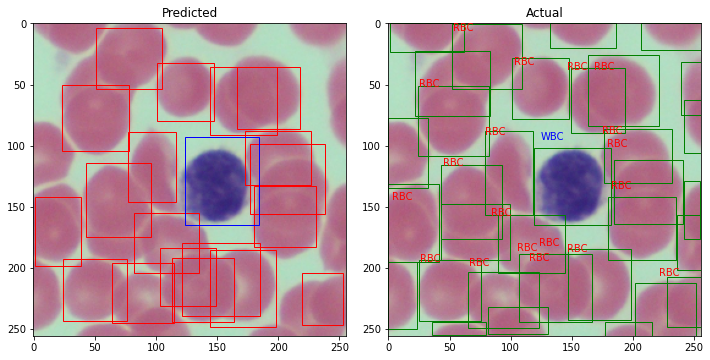



-- RBC: 100.00%
0.8288304911050829
-- RBC: 100.00%
0.7515853653391709
-- RBC: 100.00%
0.8172337666461127
-- RBC: 100.00%
0.9280577594751817
-- RBC: 99.99%
0.7281816100974033
-- RBC: 99.99%
0.9422455523084898
-- RBC: 99.98%
0.8109116805603116
-- RBC: 99.98%
0.6348330332657477
-- WBC: 99.97%
0.8039664945238455
-- RBC: 99.95%
0.7789633614940885
-- RBC: 99.95%
0.8722089538206054
-- RBC: 99.95%
0.6566289428185266
-- RBC: 99.94%
0.8085406944112252
-- WBC: 97.86%
0.4578727391614106
-- RBC: 97.30%
0.31578548031452675
-- RBC: 96.99%
0.44998059483712416
-- RBC: 96.62%
0.48456403288607724
-- RBC: 95.89%
0.5386493631053121
-- RBC: 95.60%
0.48094886692167993
-- RBC: 94.77%
0.5603608044607516


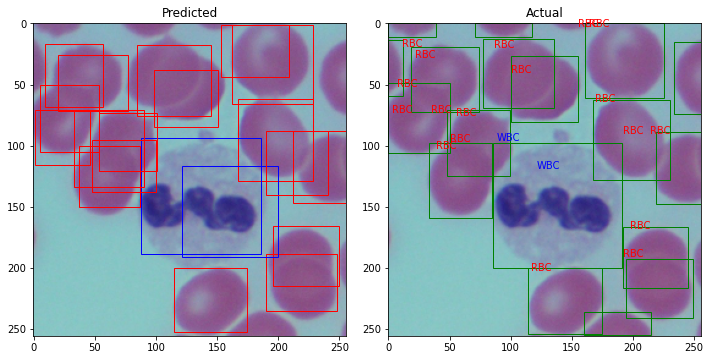



-- RBC: 100.00%
0.8461462448217074
-- RBC: 100.00%
0.5469688404763167
-- RBC: 99.99%
0.5737393071457821
-- RBC: 99.99%
0.8435600956103966
-- RBC: 99.99%
0.6356252084033079
-- RBC: 99.99%
0.7100564680604011
-- RBC: 99.98%
0.8259886690505525
-- RBC: 99.98%
0.8711755487564118
-- RBC: 99.97%
0.8403744074898811
-- RBC: 99.96%
0.7567311294176784
-- RBC: 99.95%
0.8292424124124899
-- WBC: 99.91%
0.8015282588614722
-- RBC: 99.89%
0.7237387342241746
-- RBC: 99.65%
0.6361343256812473
-- RBC: 99.58%
0.7678932894837439
-- RBC: 99.58%
0.8096386528402568
-- RBC: 99.50%
0.5084822283620044
-- RBC: 99.20%
0.6778214806867434
-- RBC: 99.18%
0.6606295062099484
-- RBC: 99.12%
0.6241983680657248


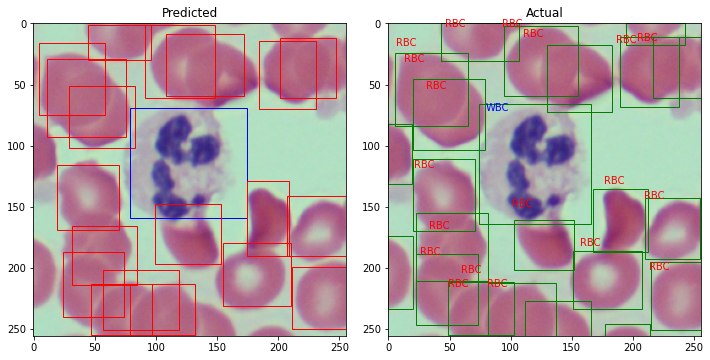



-- RBC: 100.00%
0.92852511725048
-- RBC: 100.00%
0.8288307348292532
-- RBC: 99.99%
0.7423658070736135
-- RBC: 99.99%
0.49541741533905465
-- RBC: 99.99%
0.6864334459590707
-- RBC: 99.99%
0.8515611356311992
-- RBC: 99.99%
0.8419064368539213
-- RBC: 99.98%
0.8178186361299455
-- WBC: 99.98%
0.7295262127827249
-- RBC: 99.97%
0.6458339707687727
-- RBC: 99.95%
0.7852407492216263
-- RBC: 99.94%
0.8372923810700913
-- RBC: 99.93%
0.6981288198450237
-- RBC: 99.93%
0.6658555013905628
-- RBC: 99.89%
0.8861088392117688
-- RBC: 99.85%
0.8346050909590338
-- RBC: 99.85%
0.5021561327316425
-- RBC: 99.82%
0.7677664237359566
-- RBC: 99.72%
0.6318105601080555
-- RBC: 99.67%
0.46563229351082036


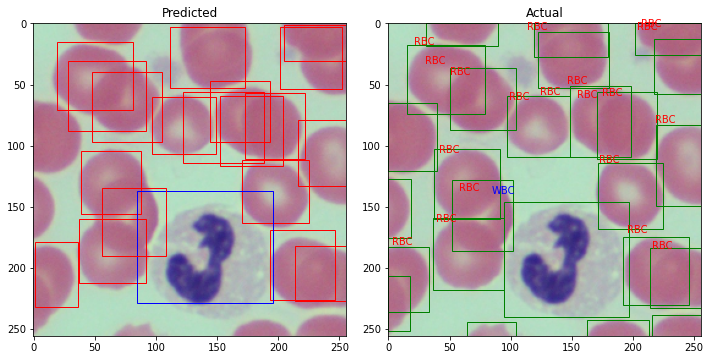



-- RBC: 99.99%
0.7651365896303574
-- RBC: 99.99%
0.6451095112196544
-- RBC: 99.99%
0.6232893337584823
-- RBC: 99.98%
0.8306533156449759
-- RBC: 99.98%
0.7360230511931729
-- WBC: 99.97%
0.740847828174888
-- RBC: 99.91%
0.7528727808094728
-- RBC: 99.90%
0.5408708850463265
-- RBC: 99.88%
0.7899976867765438
-- RBC: 99.85%
0.7894930569606085
-- RBC: 99.80%
0.8826619996425125
-- RBC: 99.58%
0.8924814455015039
-- RBC: 99.26%
0.845015513926251
-- RBC: 99.06%
0.7611888139462566
-- RBC: 98.90%
0.5723146352247069
-- RBC: 98.87%
0.6995522380694624
-- RBC: 98.21%
0.48351944757374343
-- RBC: 97.70%
0.4452486910998244
-- RBC: 97.37%
0.5606333372021486
-- RBC: 96.80%
0.7410702850232439


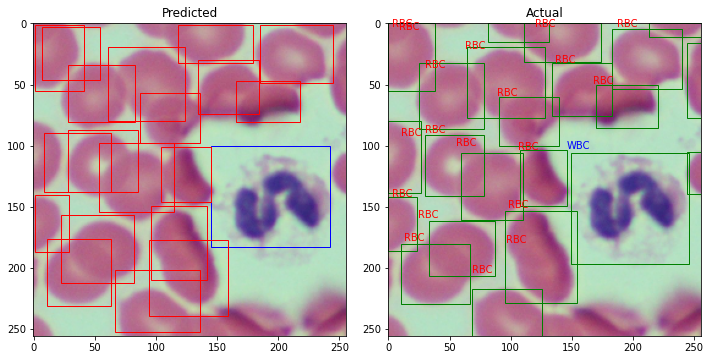



-- RBC: 100.00%
0.9364844604023919
-- RBC: 100.00%
0.8082493619412188
-- RBC: 100.00%
0.8991570392144489
-- RBC: 99.99%
0.8349179491225214
-- RBC: 99.99%
0.7932522921688205
-- RBC: 99.99%
0.7304965809638286
-- RBC: 99.97%
0.8193156403387152
-- RBC: 99.94%
0.7785519221184494
-- RBC: 99.93%
0.8772096911103093
-- RBC: 99.91%
0.7551889403119085
-- WBC: 99.90%
0.6870695464829738
-- RBC: 99.90%
0.5215678355171612
-- RBC: 99.71%
0.6950977970667825
-- RBC: 99.70%
0.46151569007534293
-- RBC: 99.53%
0.5714793464350418
-- RBC: 99.20%
0.6756682028480405
-- RBC: 99.19%
0.434011071243743
-- RBC: 99.15%
0.5092915145132365
-- RBC: 98.28%
0.37227552549595966
-- RBC: 97.65%
0.46597628705550426


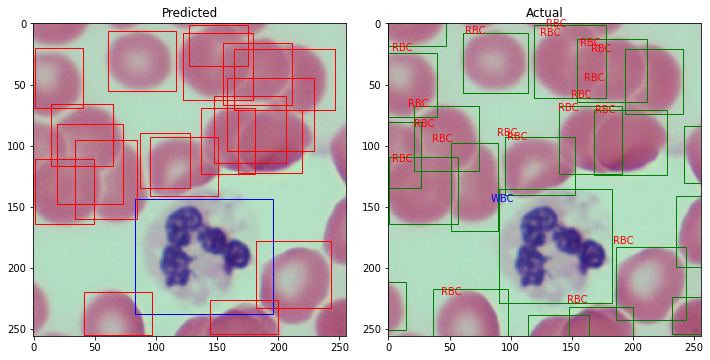



-- RBC: 100.00%
0.8930298780147782
-- RBC: 100.00%
0.8940673015313502
-- RBC: 100.00%
0.7764602215593195
-- RBC: 99.99%
0.8158903383824025
-- RBC: 99.99%
0.8838245207809043
-- WBC: 99.99%
0.7485211513713441
-- RBC: 99.99%
0.7294994255889664
-- RBC: 99.99%
0.6995318804007398
-- RBC: 99.99%
0.8023693401911676
-- RBC: 99.99%
0.7507501298210195
-- RBC: 99.97%
0.5788125373288409
-- RBC: 99.97%
0.5416660935871696
-- RBC: 99.96%
0.9355932297071853
-- RBC: 99.95%
0.9006116847041267
-- RBC: 99.94%
0.8019032557423275
-- RBC: 99.94%
0.9006198452452799
-- RBC: 99.94%
0.8162023976720355
-- RBC: 99.93%
0.8477370148415616
-- RBC: 99.90%
0.790332643446031
-- RBC: 99.86%
0.5053432025170241


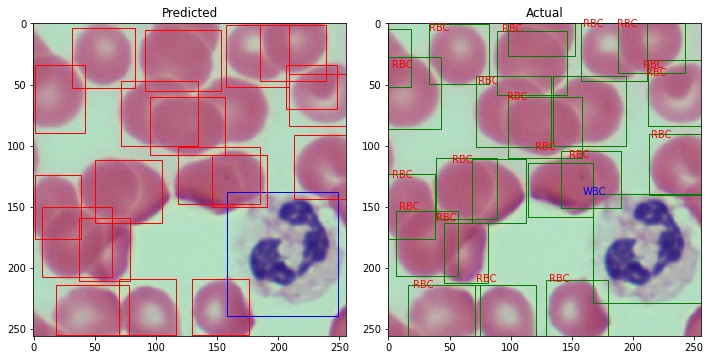



-- RBC: 100.00%
0.8848767860264195
-- RBC: 100.00%
0.8725391773511147
-- RBC: 100.00%
0.8402498794204122
-- RBC: 100.00%
0.8750265198039716
-- RBC: 99.99%
0.7519543946747314
-- RBC: 99.99%
0.7200328352008614
-- RBC: 99.99%
0.8900905656135492
-- RBC: 99.99%
0.888922260368331
-- RBC: 99.98%
0.6982251586451086
-- RBC: 99.98%
0.7895249220212858
-- RBC: 99.96%
0.6885196400217121
-- RBC: 99.94%
0.7865021295095433
-- RBC: 99.82%
0.6015290897005202
-- RBC: 99.56%
0.44134801036102494
-- WBC: 99.35%
0.6287891590868919
-- RBC: 99.25%
0.40980491760600457
-- RBC: 97.35%
0.46639116149630006
-- RBC: 97.21%
0.606034072730586
-- RBC: 97.03%
0.3191355844805449
-- RBC: 96.96%
0.5605003134688658


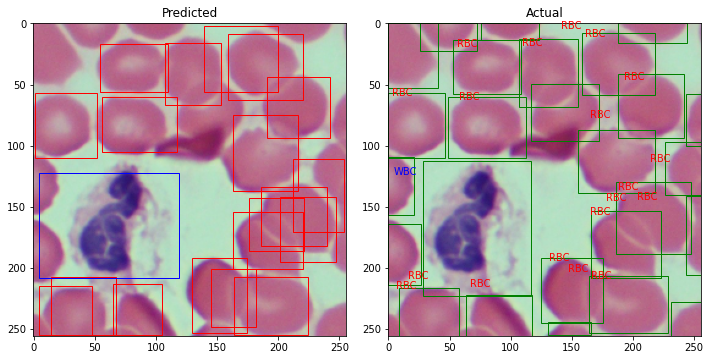



-- RBC: 100.00%
0.8388259876905644
-- RBC: 100.00%
0.7291504551169232
-- RBC: 100.00%
0.9539864149859508
-- RBC: 99.99%
0.7437176715076205
-- RBC: 99.99%
0.7933206931048477
-- RBC: 99.98%
0.698716983678745
-- WBC: 99.98%
0.9349538660210366
-- RBC: 99.98%
0.9503679590929989
-- RBC: 99.98%
0.8904869051612966
-- RBC: 99.98%
0.7493771556317954
-- RBC: 99.97%
0.765910424450134
-- RBC: 99.96%
0.8910349022688044
-- RBC: 99.93%
0.615338717654739
-- RBC: 99.91%
0.7196150356076236
-- RBC: 99.71%
0.8261124762259611
-- RBC: 99.68%
0.5415442059532162
-- RBC: 99.66%
0.740619346999107
-- RBC: 99.45%
0.5922695247784137
-- RBC: 98.80%
0.3687749876929029
-- RBC: 98.79%
0.47120168505333976


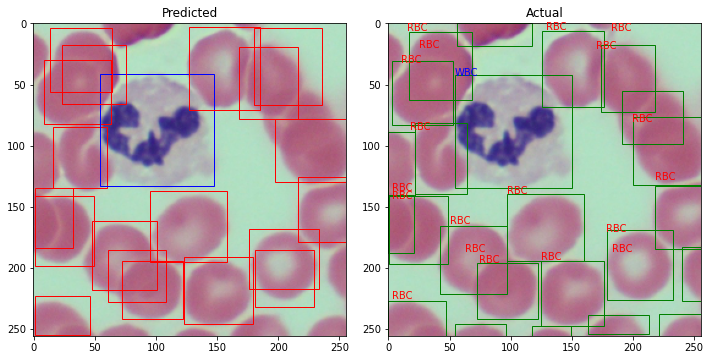



-- RBC: 100.00%
0.8223120454881724
-- RBC: 99.99%
0.83512930992745
-- RBC: 99.99%
0.7436379937180986
-- RBC: 99.99%
0.8350189799893312
-- RBC: 99.99%
0.8054332498293101
-- RBC: 99.99%
0.7497572421388385
-- RBC: 99.99%
0.8863439557152695
-- RBC: 99.98%
0.8455189689555823
-- RBC: 99.96%
0.777320141136626
-- RBC: 99.96%
0.8970066369641788
-- RBC: 99.94%
0.7320096360542319
-- RBC: 99.89%
0.8061720559808497
-- RBC: 99.87%
0.8386805900108112
-- WBC: 99.85%
0.680471297297942
-- RBC: 99.82%
0.4987910686801968
-- RBC: 99.51%
0.77761631626944
-- RBC: 99.40%
0.8076785315459651
-- RBC: 99.36%
0.43154144863027316
-- RBC: 99.18%
0.697379881129225
-- RBC: 98.58%
0.48056476602688464


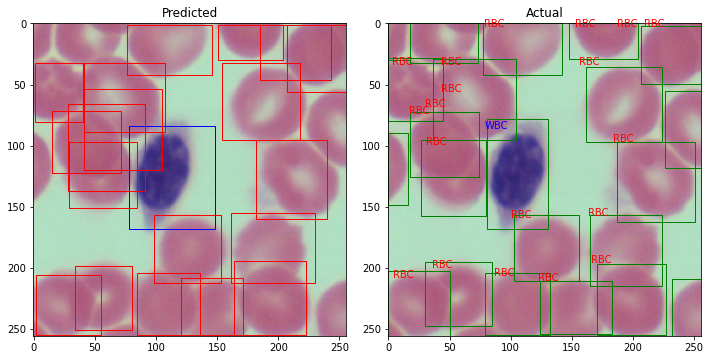



-- RBC: 100.00%
0.8688862515859688
-- RBC: 100.00%
0.800531947651889
-- RBC: 100.00%
0.6666673608295502
-- RBC: 100.00%
0.891724883431594
-- RBC: 100.00%
0.8874551124964045
-- RBC: 99.99%
0.7205918821837508
-- RBC: 99.99%
0.791084219015724
-- RBC: 99.99%
0.9121889495863678
-- RBC: 99.99%
0.9286512716882364
-- RBC: 99.99%
0.7934420639604344
-- RBC: 99.99%
0.8063495061647229
-- RBC: 99.98%
0.8550683543521753
-- RBC: 99.98%
0.8127117810987826
-- RBC: 99.97%
0.7467030192233661
-- RBC: 99.94%
0.5465303725158889
-- RBC: 99.91%
0.7573529911942087
-- RBC: 99.69%
0.5631493999495368
-- WBC: 99.68%
0.7723783826177156
-- RBC: 99.60%
0.5004172075510871
-- RBC: 99.32%
0.6409747680867519


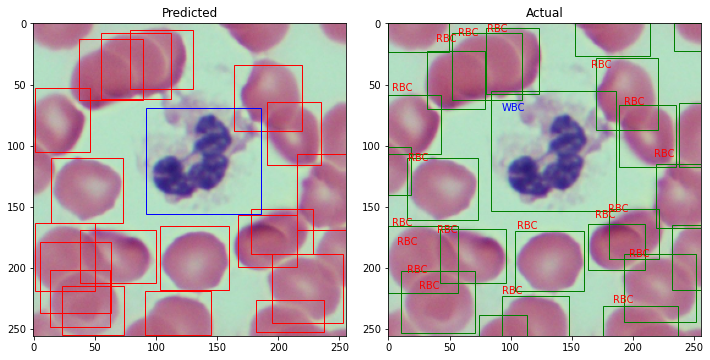



Mean IoU of test dataset 0.7259750418475761


In [19]:
images = list(set(testdf['image'].tolist()))
averageiou=[]
predictedlabels=[]
actuallabels=[]
for idx, image_name in enumerate(images):
    #print(row)

    input_image = image_name
    image = cv2.imread(input_image)  # read image in bgr format
    im = Image.open(input_image)
    # image = cv2.resize(image, (0, 0), fx=0.3, fy=0.3)
    image = np.array(image, dtype=np.float)
    image = np.uint8(image)

    display_image = image.copy()
    image_height, image_width, _ = image.shape
    height_scale, width_scale = input_size/image_height, input_size/image_width

    image = cv2.resize(image, (input_size, input_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = process_input_fn(image)

    image = np.expand_dims(image, axis=0)
    y_pred = model.predict(image)
    #print(y_pred[0])
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    pyplot.subplot(121)
    plt.imshow(im)
    pyplot.title('Predicted')
    ax = plt.gca()
    pyplot.subplot(122, sharex=ax)
    plt.imshow(im)

    pyplot.title('Actual')
    ax1 = plt.gca()
    
    for i,row in testdf[testdf['image']==image_name].iterrows():
           #print(rows['xmin'])


    
           rect1 = Rectangle((row['xmin'],row['ymin']),row['xmax']-row['xmin'],row['ymax']-row['ymin'],linewidth=1,edgecolor='green',facecolor='none',label='Label')
         
           ax1.add_patch(rect1)
           

    for i, pred in enumerate(y_pred[0]):
        
        classname = label_maps[int(pred[0]) - 1].upper()
        confidence_score = pred[1]

        score = f"{'%.2f' % (confidence_score * 100)}%"
        print(f"-- {classname}: {score}")
        

        if confidence_score <= 1 and confidence_score > 0.5:
            xmin = max(int(pred[2] / width_scale), 1)
            ymin = max(int(pred[3] / height_scale), 1)
            xmax = min(int(pred[4] / width_scale), image_width-1)
            ymax = min(int(pred[5] / height_scale), image_height-1)
            maxiou=0
            label="" 

            for i,row in testdf[testdf['image']==image_name].iterrows():
           #print(rows['xmin'])

              iou = bb_intersection_over_union([xmin,ymin,xmax,ymax],[row['xmin'],row['ymin'],row['xmax'],row['ymax']])
              if(iou>maxiou):
                maxiou=iou
                label=row['label']
            actuallabels.append(label)
            predictedlabels.append(classname.lower())
              #rect1 = Rectangle((row['xmin'],row['ymin']),row['xmax']-row['xmin'],row['ymax']-row['ymin'],linewidth=1,edgecolor='green',facecolor='none',label='Label')
              #ax1.add_patch(rect1)

            if(classname=="WBC"):
                 
                rect = Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='b',facecolor='none',label='WBC')
                centerx , centery = xmin + 0.5, ymin+2 # obviously use a different formula for different shapes

                plt.text(centerx, centery,'WBC',color='blue')

            if(classname=="RBC"):
                rect = Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none',label="RBC")
                centerx, centery = xmin+2,ymin+2 # obviously use a different formula for different shapes

                plt.text(centerx, centery,'RBC',color='red')

            print(maxiou)
            averageiou.append(maxiou)
            

            ax.add_patch(rect)
    plt.show()
    print("\n")
print("Mean IoU of test dataset",sum(averageiou)/len(averageiou))


In [17]:
print(len(predictedlabels))
print(len(actuallabels))
from sklearn.metrics import accuracy_score
accuracy_score(predictedlabels,actuallabels)

220
220


1.0

In [18]:
#!python test.py val.txt ./ ./ configs/ssd300_vgg16_pascal-voc-2007.json model.h5 --label_maps label_map.txt --output_dir ./  --num_predictions 4